# ESDIRK methods in Extensisq

Explicit method fail or struggle with stiff ODEs. Scipy implements a few important methods for stiff ODEs, but the choice is limited to BDF methods that are multistep and may have a disadvantageous stability domain at higer order, and the Radau method which is a full implicit RK method that may be overkill for your application.

Extensisq implements a few low order ESDIRK methods: two methods of Hosea and Shampine, `HS2I` (or alias `TRBDF2`) and `HS2Ia` (or alias `TRX2`), the 3rd order method of Kværnø, `Kv3I`, and 3 methods of Kennedy and Carpenter `KC3I` (original name: ESDIRK3(2)5L[2]SA), `KC4I` (original name: ESDIRK4(3)6L[2]SA) and `KC4Ia` (original name: ESDIRK4(3)7L[2]SA). These implicit methods have a few extra options that are demonstrated in this notebook.

## Linear problem of Hosea: Stiffness, Jacobian definition and linearity
Let's start with the linear problem from the paper of Hosea.
$$\boldsymbol{y}^\prime = \begin{bmatrix} -500 & 0 \\ 0 & -1 \end{bmatrix}\boldsymbol{y} + \begin{Bmatrix} 500 \cos (t) - \sin (t) \\ \sin (t) + \cos (t) \end{Bmatrix}$$

Which has solution $y_1 = \cos(t), y_2 = \sin(t)$ with appropriate initial conditions.

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
from extensisq import TRX2, Me4

y0 = np.array([1., 0.])
t_span = (0., 12.)

def fun(t, y):
    dy0 = -500*y[0] + 500*np.cos(t) - np.sin(t)
    dy1 = -y[1] + np.sin(t) + np.cos(t)
    return np.asarray([dy0, dy1])

print("solving with explicit method...")
sole = solve_ivp(fun, t_span, y0, method=Me4)
print(f"message case 1: {sole.message}")
print(f"Nr of function evaluations: {sole.nfev}")

print("\nsolving with implicit method (numerical Jacobian)...")
soln = solve_ivp(fun, t_span, y0, method=TRX2)
print(f"message case 1: {soln.message}")
print(f"Nr of function evaluations: {soln.nfev}")
print(f"Nr of Jacobian evaluations: {soln.njev}")
print(f"Nr of LU decompositions: {soln.nlu}")

solving with explicit method...
message case 1: The solver successfully reached the end of the integration interval.
Nr of function evaluations: 8491

solving with implicit method (numerical Jacobian)...
message case 1: The solver successfully reached the end of the integration interval.
Nr of function evaluations: 238
Nr of Jacobian evaluations: 5
Nr of LU decompositions: 38


This problem has some mild stiffness and can still be integrated with an explicit method. However, as the test above shows, the explicit method needs ~35 times as many function evaluations making it very inefficient. On the other hand, implicit methods need to solve a system of equations (iteratively if the ODE is non-linear). This has costs for to the assembly of the Jacobian and the LU decomposition of the implicit system matrix.

In the example above, the implicit method was called without the `jac` argument. This makes the method use an finite difference estimate of the Jacobian. This is typically a costly procedure that needs many function evaluations that are not counted in `solution.nfev`. Although the method works fine here and it is convenient for the user not to bother with the Jacobian, using numerical Jacobians is not recommended in general. Robustness and efficiency may suffer for many problems.

The Jacobian of the ODE, is defined as:
$$\frac{\partial \boldsymbol{f}(t, \boldsymbol{y})}{\partial \boldsymbol{y}} = \begin{bmatrix}
\frac{\partial f_1}{\partial y_1} & \cdots & \frac{\partial f_1}{\partial y_n} \\ 
\vdots & \ddots & \vdots \\
\frac{\partial f_n}{\partial y_1} & \cdots & \frac{\partial f_n}{\partial y_n} \end{bmatrix}.$$
For the current linear problem it is simply the matrix that is also used in the problem definition above. It can passed as a dense or sparse array or as a function. **For linear problems it is recommended to pass the Jacobian as an array.**

In [2]:
jac = np.array([[-500, 0], [0, -1.]])

print("solving with implicit method (matrix Jacobian)...")
solm = solve_ivp(fun, t_span, y0, jac=jac, method=TRX2)
print(f"message case 1: {solm.message}")
print(f"Nr of function evaluations: {solm.nfev}")
print(f"Nr of Jacobian evaluations: {solm.njev}")
print(f"Nr of LU decompositions: {solm.nlu}")

solving with implicit method (matrix Jacobian)...
message case 1: The solver successfully reached the end of the integration interval.
Nr of function evaluations: 109
Nr of Jacobian evaluations: 0
Nr of LU decompositions: 48


The number of function evaluations roughly halved, because only one iteration is needed to solve a linear stage. On the other hand, the number of LU decompositions has increased. A new decomposition is calculated each time the step size changes.

Another option is to pass the Jacobian with a function.

In [3]:
def jac_fun(t, y, jac=jac):
    return jac

print("solving with implicit method (callable Jacobian)...")
solf = solve_ivp(fun, t_span, y0, jac=jac_fun, method=TRX2)
print(f"message case 1: {solf.message}")
print(f"Nr of function evaluations: {solf.nfev}")
print(f"Nr of Jacobian evaluations: {solf.njev}")
print(f"Nr of LU decompositions: {solf.nlu}")

solving with implicit method (callable Jacobian)...
message case 1: The solver successfully reached the end of the integration interval.
Nr of function evaluations: 261
Nr of Jacobian evaluations: 9
Nr of LU decompositions: 30


As you can see, the number of function evaluations increases substantially, because at least 2 iteration are needed to confirm a converged stage solution. The number of LU decompositions is reduced again. Moreover, the jacobian is evaluated quite a few times. Clearly, the heuristics of the method don't detect that the system is linear. Otherwise, the Jacobian function would be called only once. These heuristics may be suboptimal, but erring on the conservative side may not be bad overall. (Failed steps can be costly.)

The main implication is to **always use a function for `jac` if the ODE is non-linear**, even if you want to use a constant approximate Jacobian! This behavior is different from the implicit methods in scipy.

You can force a Jacobian update each step for non-linear problems with argument `jac_each_step`. However, the minimum number of iterations per stage then still remains 2. 

### comparing the errors

It is interesting to compare the errors. A plot is made to view the errors in one glance:

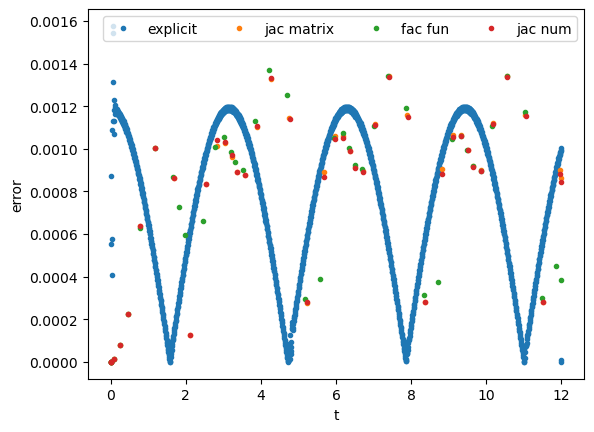

In [4]:
import matplotlib.pyplot as plt

def ref(t):
    return np.stack([np.cos(t), np.sin(t)])

def err_norm (t, y):
    err = y - ref(t)
    return np.sum(err**2, axis=0)**0.5

plt.figure()
for sol, label in zip([sole, solm, solf, soln], 
                      ['explicit', 'jac matrix', 'fac fun', 'jac num']):
    plt.plot(sol.t, err_norm(sol.t, sol.y), '.', label=label)
plt.legend(ncol=4)
plt.xlabel('t')
plt.ylabel('error')
plt.show()

These errors are with respect to the actual solution, not the estimated errors from the embedded methods. The errors in the plot are rather similar. So, even though the explicit method uses many small steps, this does not lead to a reduced error (but also not to a larger cumulated error).



## Singular perturbation problem and index 1 DAE: mass matrix form

The second problem in this notebook is Kaps' problem as given in the paper of Kennedy and Carpenter. This is a singular perturbation problem (SPP) that becomes a differential algebraic equation (DAE), as opposed to ODE, in the limit.

The paper defines Kaps' problem as:
$$ \begin{Bmatrix} y_1^\prime \\ y_2^\prime \end{Bmatrix} = \begin{Bmatrix} -(\epsilon^{-1} + 2) y_1 + \epsilon^{-1}y_2^2 \\ y_1 - y_2 - y_2^2 \end{Bmatrix} $$
with exact solution $y_1 = y_2^2$,  $y_2 = \exp (-t)$. In this problem $\epsilon$ is a parameter that turns the problem into a DAE in the limit $\epsilon = 0$.

It is inconvencient and numerically problematic to have terms $\epsilon^{-1}$ in the equation that go to infinity for small $\epsilon$. Therefore, the problem is rewritten by multiplying the first equation by $\epsilon$ and introducing a 'mass' matrix on the left hand side:
$$ \begin{bmatrix} \epsilon & 0 \\ 0 & 1 \end{bmatrix} \begin{Bmatrix} y_1^\prime \\ y_2^\prime \end{Bmatrix} = \begin{Bmatrix} -(1 + 2 \epsilon) y_1 + y_2^2 \\ y_1 - y_2 - y_2^2 \end{Bmatrix} $$
The ESDIRK solvers in Extensisq (`TRBDF2`/`HS2I`, `TRX2`/`HS2Ia`, `KC3I`, `KC4I`, `KC4Ia` and `Kv3I`) accept initial value problems in this form directly, as long as the mass matrix is constant and the index of the DAE is not higher than 1.

Let's solve this problem and deal with some intricacies along the way.

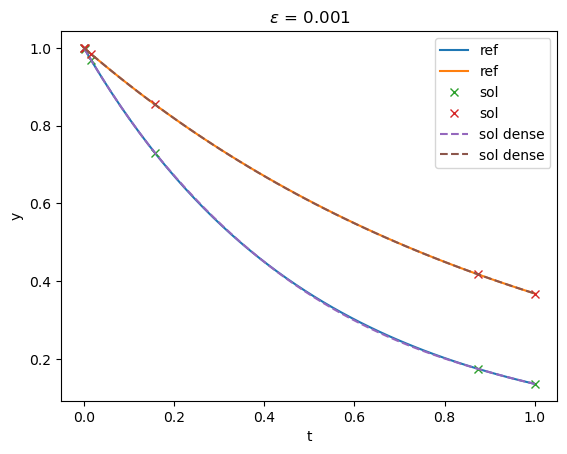

In [5]:
from extensisq import KC3I

def fun2(t, y, eps):
    return np.array([-(1 + 2*eps)*y[0] + y[1]**2,
            y[0] - y[1] - y[1]**2])

def jac2(t, y, eps):
    return np.array([[-(1 + 2*eps), 2*y[1]],
                    [1, -1 - 2*y[1]]])

def ref2(t):
    return np.stack([np.exp(-t)**2, np.exp(-t)])

t_span2 = (0, 1.)
y02 = [1., 1.]

eps = 1e-3
M = [eps, 1]

sol2 = solve_ivp(fun2, t_span2, y02, jac=jac2, args=(eps,), method=KC3I,
                 M=M, dense_output=True)

t = np.linspace(*t_span2)
plt.figure()
plt.plot(t, ref2(t).T, label='ref')
plt.plot(sol2.t, sol2.y.T, 'x', label='sol')
plt.plot(t, sol2.sol(t).T, '--', label='sol dense')
plt.legend()
plt.title(f'$\epsilon$ = {eps}')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

Notice that only the diagonal of the mass matrix is supplied. The smooth solution is calculated, but the initial step size is relatively small. It helps that the initial value is close to the reference solution. What happens if we choose another initial value?

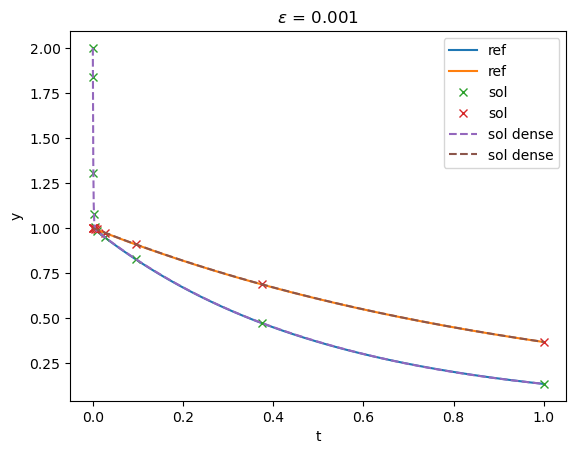

In [6]:
y02a = [2., 1.]

sol2a = solve_ivp(fun2, t_span2, y02a, jac=jac2, args=(eps,), method=KC3I,
                  M=M, dense_output=True)

t = np.linspace(*t_span2, 2000)
plt.figure()
plt.plot(t, ref2(t).T, label='ref')
plt.plot(sol2a.t, sol2a.y.T, 'x', label='sol')
plt.plot(t, sol2a.sol(t).T, '--', label='sol dense')
plt.legend()
plt.title(f'$\epsilon$ = {eps}')
plt.xlabel('t')
plt.ylabel('y')
# plt.xlim(0, 0.05)
plt.show()

You can zoom in on the very first part of the solution and see how the solution rapidly goes to the reference. Thereafter, it becomes smooth and the step size increases.

The smaller $\epsilon$ becomes, the stronger this initial correction becomes. In the limit where $\epsilon$ = 0, we are solving a DAE. The upper equation $0=-y_1 + y_2^2$ is the algebraic constraint and the current initial value violates it. What happenens if we try to solve it anyway?

C:\Users\Gebruiker\Documents\GitHub\extensisq\extensisq\common.py:1889: UserWarning: 
Initial conditions are changed to y0 = [1. 1.] to
make them consistent with the algebraic constraints.
This is not updated in OdeResults.y if t_eval is None.
Call solve_ivp again with a consistent y0 if this is
a problem.
  warn(f"\nInitial conditions are changed to y0 = {y} to"


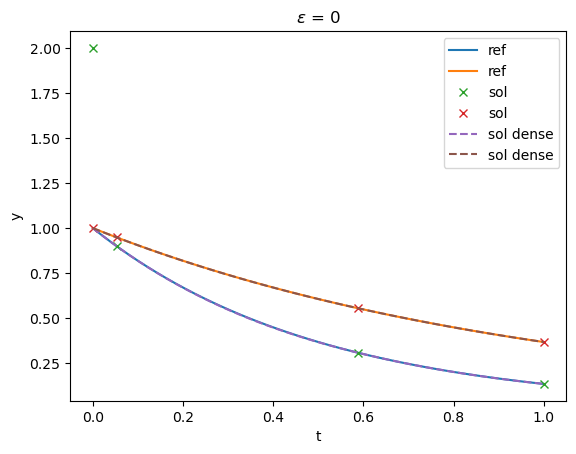

In [7]:
eps = 0
M0 = [0, 1]

sol3 = solve_ivp(fun2, t_span2, y02a, jac=jac2, args=(eps,), method=KC3I,
                 M=M0, dense_output=True, interpolant='C1')

t = np.linspace(*t_span2)

plt.figure()
plt.plot(t, ref2(t).T, label='ref')
plt.plot(sol3.t, sol3.y.T, 'x', label='sol')
plt.plot(t, sol3.sol(t).T, '--', label='sol dense')
plt.legend()
plt.title(f'$\epsilon$ = {eps}')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

Extensisq issues a warning that the initial conditions does not satisfy the algebraic constraint and proposes another initial value that does. It then continues solving. (Using the corrected initial condition.)

In this case, the upper row of the mass matrix zero and therefore the the first value in y0 is changed and the other value is fixed. (This becomes harder to explain for a full mass matrix.) Notice in the plot that `sol3.y` still contains the y0 given by the user, but the dense output starts at the corrected consistent value shown in the warning.

Extensisq also calculates a consistent value for the derivative from the algebraic constraint. The C1 continuous interpolator is used to show this in the plot. There would have been a clear interpolation error in the first step without it. The calculation of the derivative is trivial for an ODE: $\dot{y}=M^{-1}f(t_0, y_0)$. For a DAE however, the mass matrix is not invertible and the initial derivative must be calculated from the Jacobian instead. Extensisq does this calculation without user input.

Also notice that first time step has a reasonable size. It is much larger than in the perturbation problem with an inconsistent initial value discussed before. 

The algebraic constraint is not directly enforced for the other steps. The method does the iteration for the differential and algebraic equations together using a quasi-Newton iteration with matrix $(M - h a_{ii} J)$ where $h$ and $J$ are step size and Jacobian and $a_{ii}$ is a Runge Kutta coefficient of the method. This matrix can be used for multiple steps. Extensisq scales the algebraic equations to counter ill conditioning that may occur at very small $h$. We can check if the constraint $y_2^2-y_1=0$ is satified in this example.

In [8]:
y = sol3.y
err_alg = y[1, :]**2 - y[0, :]

print(f'{err_alg = }')

err_alg = array([-1.,  0.,  0.,  0.])


The constraint is not satisfied at the initial value, as we already knew. This is indicated by the non-zero error value. Constraint errors at the other steps are all 0. So, the method clearly works well for this problem.